In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy
import scipy.io
from scipy import stats

# Hello Soft Clustering (GMM)

In [2]:
class GaussianMixtureModel:
    def __init__(self, n_mixtures = 3, mode=None):
        if mode == "T1":
            n_mixtures = 3
            self.means = np.array([[3, 3], [2, 2], [-3, -3]], dtype=np.float64)
            self.verbose = True
            
        elif mode == "T3":
            n_mixtures = 2
            self.means = np.array([[3, 3],[-3, -3]], dtype=np.float64)
            self.verbose = True

        elif mode == "OT1":
            n_mixtures = 2
            self.means = np.array([[0,0],[10_000, 10_000]], dtype=np.float64)
            self.verbose = True

        self.n_mixtures = n_mixtures
        self.weights = np.full(n_mixtures, 1 / n_mixtures, dtype=np.float64)

    def _expectation_step(self, X):
        W = np.vstack([ stats.multivariate_normal(self.means[j], self.covs[j]).pdf(X) * self.weights[j]
                        for j in range(self.n_mixtures) ]).T
        return W / W.sum(axis=1, keepdims=True) #normalize

    def _maximization_step(self, X, W):
        self.weights = W.sum(axis=0) / W.shape[0]
        self.means = W.T @ X / W.sum(axis=0).reshape(-1, 1)

        self.covs = np.stack([
            ( (X - self.means[j]).T * W[:, j] ) @ (X - self.means[j]) / W[:, j].sum()
            for j in range(self.n_mixtures)
        ])
        self.covs[:, np.eye(X.shape[1])==0] = 0 # Σ_(i,j) = 0, for i != j.
        
    def _calculate_likelihood(self, X):
        W = np.vstack([ stats.multivariate_normal(self.means[j], self.covs[j]).pdf(X) * self.weights[j]
                        for j in range(self.n_mixtures) ]).T
            
        self.log_likelihoods.append( np.log( W.sum(axis=1) ).sum() )
        
     
    def fit(self, X, epochs=3):
        
        num_samples, num_features = X.shape
        self.covs = np.stack( [ np.eye(num_features, dtype=np.float64) for _ in range(self.n_mixtures) ] )
        self.log_likelihoods = []
        
        for epoch in range(epochs):
            if self.verbose:
                print(f"epoch {epoch+1}:")
                print(127 * '*')
                
            W = self._expectation_step(X)
            self._maximization_step(X, W)

            if self.verbose:
                self.describe(X, W, num_features)
            
            self._calculate_likelihood(X)
            
           
        return self

    def plot_likelihood(self):
        plt.title('log likelihood')
        plt.xlabel('epochs')
        plt.xticks([1,2,3])
        plt.plot(range(1, len(self.log_likelihoods)+1), self.log_likelihoods)
        plt.show()

    def plot_gauss_iteration(self):
        pass
        
    def describe(self, X, W, num_features):
        print(60*'-', 'W_n,j', 60*'-')
        for i, w in enumerate(W):
            print(f"({X[i, 0]}, {X[i, 1]}): ", *w, sep='\t\t\t')
        print(127 * '-')
        
        print(61*'-', 'm_j', 61*'-')
        print('', *self.weights, sep='\t\t\t')
        print(127 * '-')
        
        print(61*'-', 'μ_j', 61*'-')
        print('', *[f'({x:.7f}, {y:.7f})' for x,y in self.means], sep='\t\t\t')
        print(127 * '-')
        
        print(61*'-', 'Σ_j', 61*'-')
        for row in range(num_features):
            print('', *self.covs[:, row, :] , sep='\t\t\t')
        print(127 * '*')


## T1, T2

epoch 1:
*******************************************************************************************************************************
------------------------------------------------------------ W_n,j ------------------------------------------------------------
(1.0, 2.0): 			0.11920292180570964			0.8807970763788322			1.8154580846115228e-09
(3.0, 3.0): 			0.7310585786300048			0.2689414213699951			1.6957070633777055e-16
(2.0, 2.0): 			0.2689414213672646			0.7310585786225826			1.0152900501910824e-11
(8.0, 8.0): 			0.9999832985781519			1.6701421848095123e-05			2.0310587405994306e-42
(6.0, 6.0): 			0.9990889488055994			0.0009110511944006453			5.375284534993934e-32
(7.0, 7.0): 			0.9998766054240137			0.00012339457598623172			3.3052927212335458e-37
(-3.0, -3.0): 			2.3195228302113496e-16			1.3887943864771155e-11			0.9999999999861118
(-2.0, -4.0): 			2.319522830211349e-16			1.3887943864771157e-11			0.9999999999861118
(-7.0, -7.0): 			3.3057006267607222e-37			5.900090541597041e-29			1.0
---

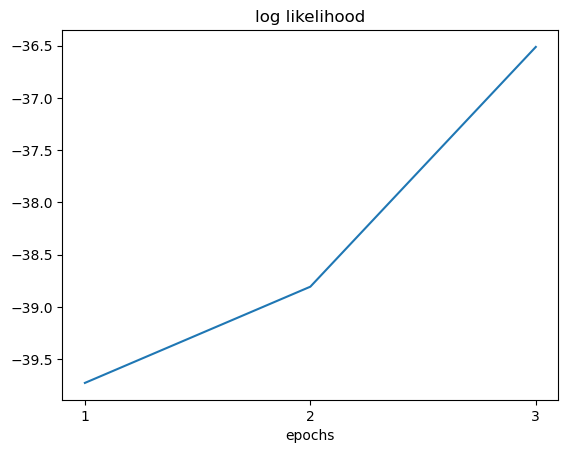

In [3]:
data = np.array([[1, 2], [3, 3], [2, 2], [8, 8], [6, 6], [7, 7], [-3, -3], [-2, -4], [-7, -7]], dtype=np.float64)
gmm_t1 = GaussianMixtureModel(mode="T1").fit(data)
gmm_t1.plot_likelihood()

## T3, T4

epoch 1:
*******************************************************************************************************************************
------------------------------------------------------------ W_n,j ------------------------------------------------------------
(1.0, 2.0): 			0.9999999847700205			1.5229979512760363e-08
(3.0, 3.0): 			0.9999999999999998			2.319522830243563e-16
(2.0, 2.0): 			0.9999999999622486			3.775134544136584e-11
(8.0, 8.0): 			1.0			2.031092662734804e-42
(6.0, 6.0): 			1.0			5.380186160021119e-32
(7.0, 7.0): 			1.0			3.3057006267607226e-37
(-3.0, -3.0): 			2.319522830243563e-16			0.9999999999999998
(-2.0, -4.0): 			2.3195228302435627e-16			0.9999999999999998
(-7.0, -7.0): 			3.3057006267607226e-37			1.0
-------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------- m_j -------------------------------------------------------------
			0.66

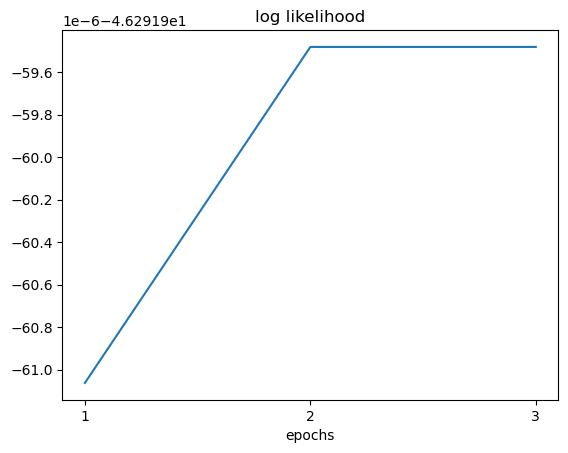

In [4]:
gmm_t3 = GaussianMixtureModel(mode="T3").fit(data)
gmm_t3.plot_likelihood()

### T4 ans
The three mixture model has higher log likelihood

## OT1

In [5]:
try:
    gmm_ot1 = GaussianMixtureModel(mode="OT1").fit(data)
except:
    print('Got Nan. Very Sad')

epoch 1:
*******************************************************************************************************************************
------------------------------------------------------------ W_n,j ------------------------------------------------------------
(1.0, 2.0): 			1.0			0.0
(3.0, 3.0): 			1.0			0.0
(2.0, 2.0): 			1.0			0.0
(8.0, 8.0): 			1.0			0.0
(6.0, 6.0): 			1.0			0.0
(7.0, 7.0): 			1.0			0.0
(-3.0, -3.0): 			1.0			0.0
(-2.0, -4.0): 			1.0			0.0
(-7.0, -7.0): 			1.0			0.0
-------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------- m_j -------------------------------------------------------------
			1.0			0.0
-------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------- μ_j -----------------------------------------

/var/folders/wh/91lwmxs51lb2njldckd6jd440000gp/T/ipykernel_37408/838807285.py:28: RuntimeWarning: invalid value encountered in divide
  self.means = W.T @ X / W.sum(axis=0).reshape(-1, 1)


### OT1 ans
The $m_2$ is equal to $0$ which implies that the model intepret that data are distributed only from 1 mixture. The reason is that initial point is very far from the data points. To prevent this situation, set the initial point on the sample data like the K-mean does.

# The face database

In [6]:
data = scipy.io.loadmat('facedata.mat')
num_persons, num_images = data['facedata'].shape
img_h, img_w = data['facedata'][0, 0].shape

In [7]:
from skimage import img_as_float

xf = { (i, j) : img_as_float(data['facedata'][i, j]) 
            for i in range(num_persons) 
            for j in range(num_images) }

## T5

In [8]:
print('Euclidean distance between xf[0, 0] and xf[0, 1]', np.sqrt( np.power(xf[0, 0] - xf[0, 1], 2).sum() ) )
print('Euclidean distance between xf[0, 0] and xf[1, 0]', np.sqrt( np.power(xf[0, 0] - xf[1, 0], 2).sum() ) )

Euclidean distance between xf[0, 0] and xf[0, 1] 10.037616294165492
Euclidean distance between xf[0, 0] and xf[1, 0] 8.173295099737281


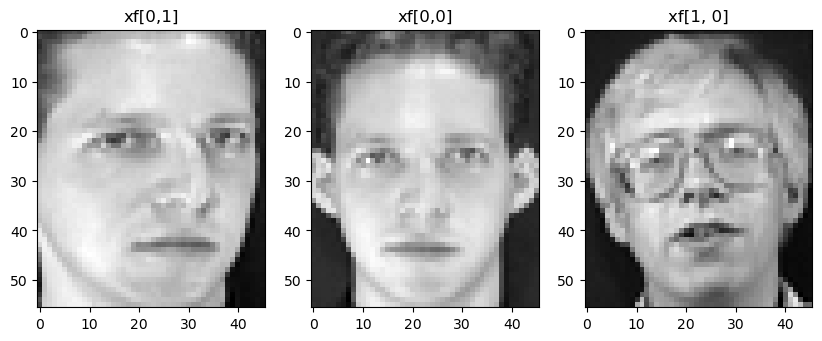

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(10, 10))
ax[0].imshow(xf[0, 1], cmap='gray')
ax[0].set_title('xf[0,1]')

ax[1].imshow(xf[0, 0], cmap='gray')
ax[1].set_title('xf[0,0]')

ax[2].imshow(xf[1, 0], cmap='gray')
ax[2].set_title('xf[1, 0]')
plt.show()

### T5 ans:
The euclidean distance seem doesn't make sense because the same person must has higher similarity than other person. The main reason is $xf[0, 0]$ and $xf[1, 0]$ has share many black spots which yield small distance values

## T6

In [10]:
def compute_similarity_matrix(T, D):
    return np.sqrt( np.power(T[:, np.newaxis, :] - D, 2).sum(axis=2) )

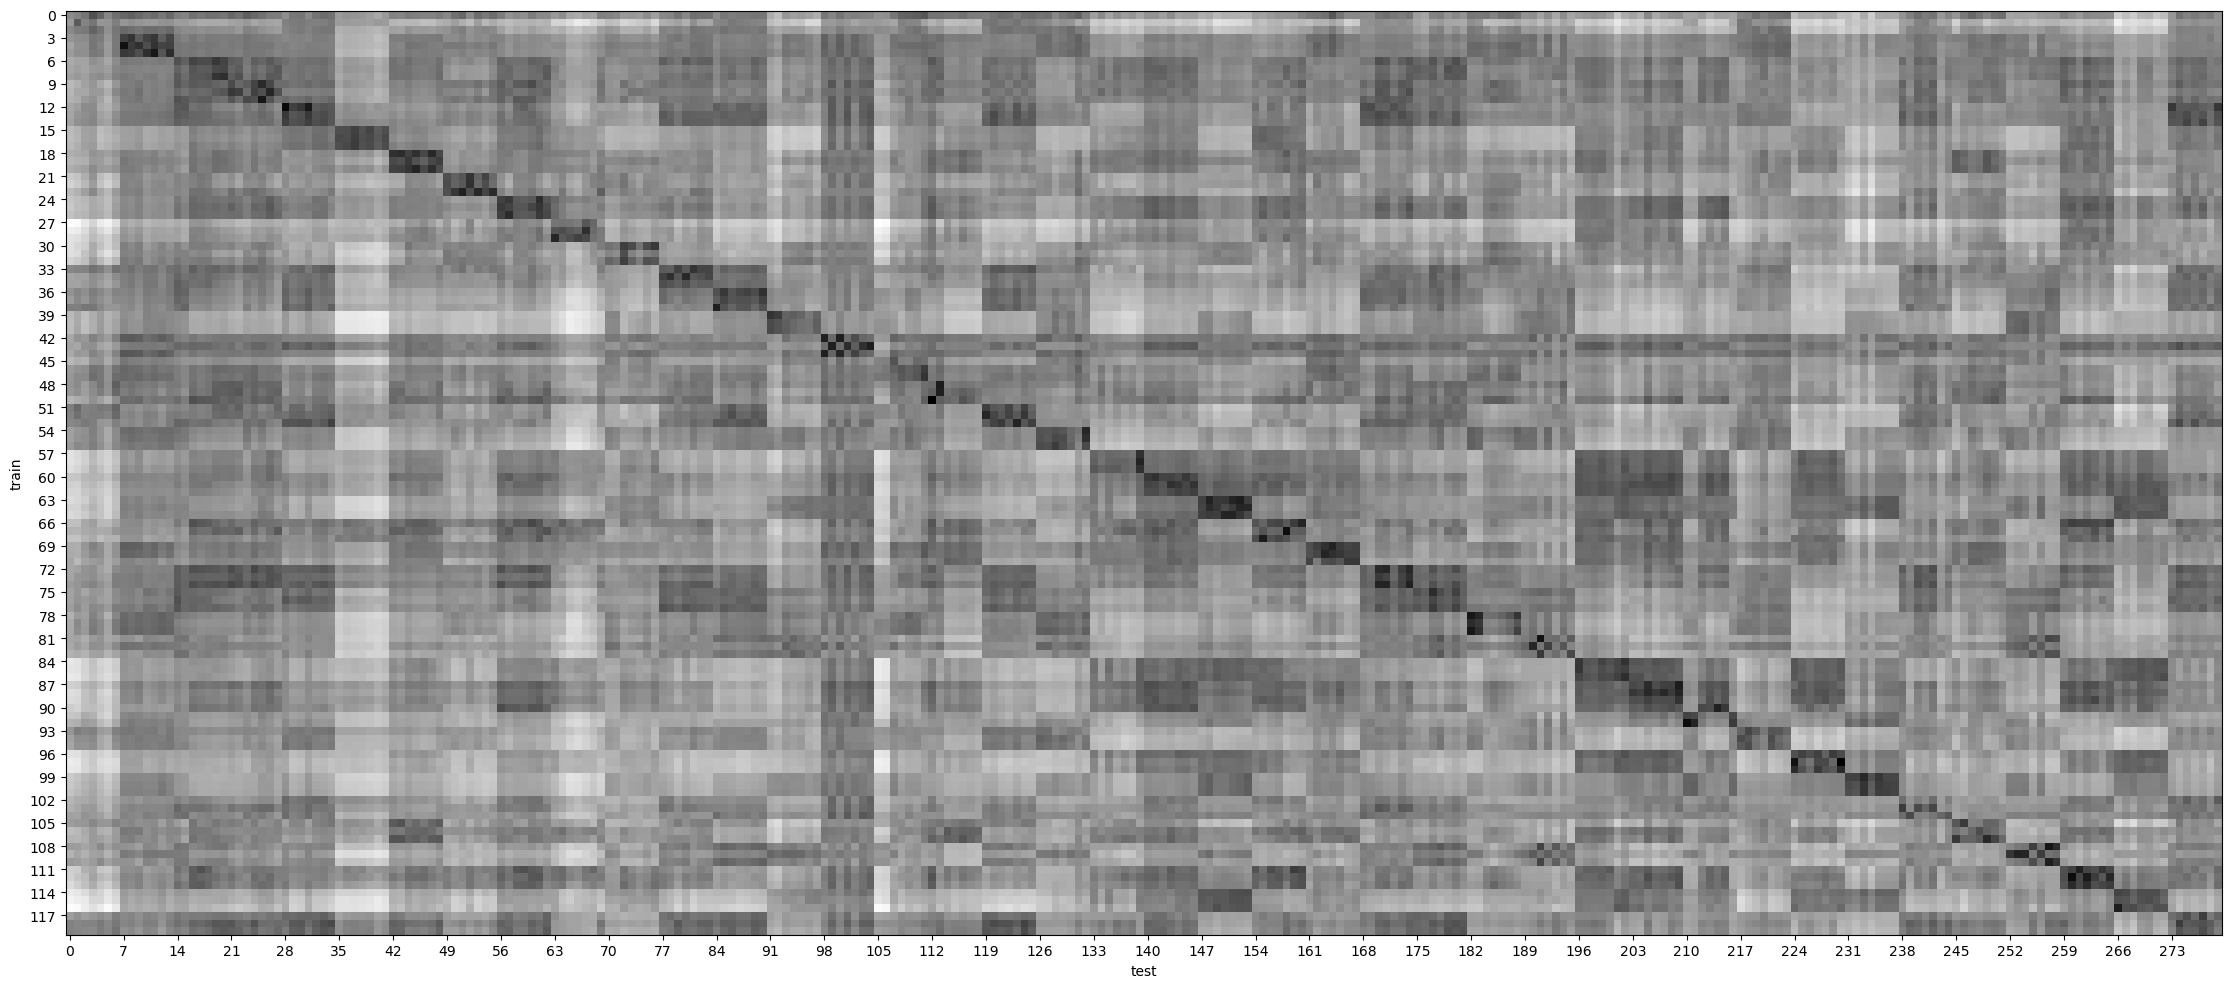

person 1


,0,1,2,3,4,5,6,7,8,9,...,270,271,272,273,274,275,276,277,278,279
0,10.369606,9.848695,8.996228,6.742481,7.975400,9.991797,8.618199,8.070297,7.671553,8.310970,...,12.896797,14.025518,13.461977,11.063111,8.861481,9.816839,9.219246,9.896388,9.361519,10.660626
1,11.249875,7.417211,9.880670,9.015946,11.040278,10.901092,9.585383,10.959881,10.583454,10.958266,...,14.965500,15.837001,15.333624,11.240393,10.691312,10.954066,10.470241,10.969427,10.902390,10.936306
2,10.222093,9.413216,9.299877,7.861811,8.883991,10.678250,9.084197,8.274936,8.595986,8.968311,...,14.082668,14.632209,14.351621,10.621731,9.610012,9.826431,9.814474,9.996895,9.944995,10.410081
3,10.945727,10.499381,10.369089,9.118717,9.401359,11.073716,9.223274,5.842049,5.063729,7.251770,...,11.343069,12.112799,11.426320,10.784801,9.800406,9.963266,9.910681,10.045208,9.384494,10.432161
4,11.921229,10.748505,10.642385,8.981316,9.789288,11.375868,9.280341,2.796472,5.497650,4.775989,...,11.404157,12.068349,11.176825,10.123507,9.754289,9.758180,9.786770,9.966323,9.928984,10.053046


In [11]:
T = np.array([xf[i, j].flatten() for i in range(num_persons) for j in range(3)])
D = np.array([xf[i, j].flatten() for i in range(num_persons) for j in range(3, num_images)])

sim_mat = compute_similarity_matrix(T, D)
plt.figure(figsize=(28, 12))

plt.xlabel('test')
plt.ylabel('train')
plt.xticks(np.arange(0, 280, 7))
plt.yticks(np.arange(0, 120, 3))

plt.imshow(sim_mat, cmap='gray')

plt.show()
print('person 1')
pd.DataFrame(sim_mat).head()

## T7

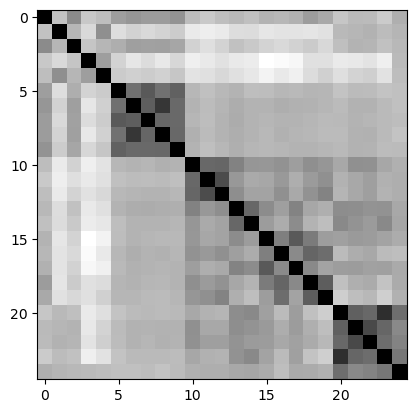

In [12]:
T7 = np.array([xf[i, j].flatten() for i in range(5) for j in range(5)])

A = compute_similarity_matrix(T7, T7)
plt.imshow(A, cmap='gray')
plt.show()

In [13]:
pd.DataFrame(A[5:10, 5:10])

,0,1,2,3,4
0,0.000000,5.824298,4.620959,5.842049,5.063729
1,5.824298,0.000000,4.876667,2.796472,5.497650
2,4.620959,4.876667,0.000000,5.309403,5.494179
3,5.842049,2.796472,5.309403,0.000000,5.415199
4,5.063729,5.497650,5.494179,5.415199,0.000000


In [14]:
pd.DataFrame( A[:5, :5] )

,0,1,2,3,4
0,0.000000,10.037616,7.187433,10.369606,9.848695
1,10.037616,0.000000,9.419973,11.249875,7.417211
2,7.187433,9.419973,0.000000,10.222093,9.413216
3,10.369606,11.249875,10.222093,0.000000,8.204364
4,9.848695,7.417211,9.413216,8.204364,0.000000


### T7 ans
- The black square show that images of person number 2 have high similarity to each other images of himself.
- The images of person number 1 has low to medium similarity to himself because the pattern color is in light gray range.

# A simple face verification system

## T8

In [15]:
def recall_score(y_test, y_pred):
    if y_test.sum():
        return np.sum((y_test == 1) & (y_pred == 1)) / y_test.sum()
    return 0

def fpr_rate(y_test, y_pred):
    if (1 - y_test).sum():
        return np.sum((y_test == 0) & (y_pred == 1)) / (1 - y_test).sum()
    return 0
    
def get_eval(train, test, train_sz, test_sz, n_persons, threshold):
    y_pred = _get_prob(train, test, train_sz, test_sz, n_persons) < threshold
    y_test = np.repeat(np.eye(n_persons), test_sz, axis=1)
    return recall_score(y_test, y_pred), fpr_rate(y_test, y_pred)

def _get_prob(train, test, train_sz, test_sz, n_persons):
    sim_mat = compute_similarity_matrix(train, test)
    prob = sim_mat.reshape(n_persons, train_sz, n_persons, test_sz).min(axis=1).reshape(n_persons, -1)
    return prob

In [16]:
tpr, fpr = get_eval(T, D, 3, 7, num_persons, 10)
print(f"tpr: {tpr}", f"fpr: {fpr}", sep='\n')

tpr: 0.9964285714285714
fpr: 0.4564102564102564


## T9

In [17]:
def roc_curve(train, test, train_sz, test_sz, n_persons, print_threshold=False):
    prob = _get_prob(train, test, train_sz, test_sz, n_persons)
    mn, mx = prob.min(), prob.max()
    if print_threshold:
        print('(min, max) threshold ->', f"({mn} , {mx})" )
    thresholds = np.linspace(mn, mx, 1000)
    y = np.repeat(np.eye(n_persons), test_sz, axis=1)
    fpr_s, tpr_s = zip(*[ (fpr_rate(y, y_pred:=prob<threshold), recall_score(y, y_pred)) 
                        for threshold in thresholds ])
    return np.array(fpr_s), np.array(tpr_s), thresholds

def plot_roc(train, test, train_sz, test_sz, n_persons, print_threshold=False):
    fpr, tpr, thresholds = roc_curve(train, test, train_sz, test_sz, n_persons, print_threshold=print_threshold)
    plt.plot(fpr, tpr)
    plt.axline((0, 0), slope=1, c='k', linestyle = '--', alpha=0.5, label='baseline')
    plt.axline((1, 0), slope=-1, c='r', label='EER')
    
    plt.xlabel('false positive(alarm) rate')
    plt.ylabel('true positive rate (recall)')
    
    plt.legend()
    plt.show()
    return fpr, tpr, thresholds

(min, max) threshold -> (1.7420153428787784 , 16.434561906764714)


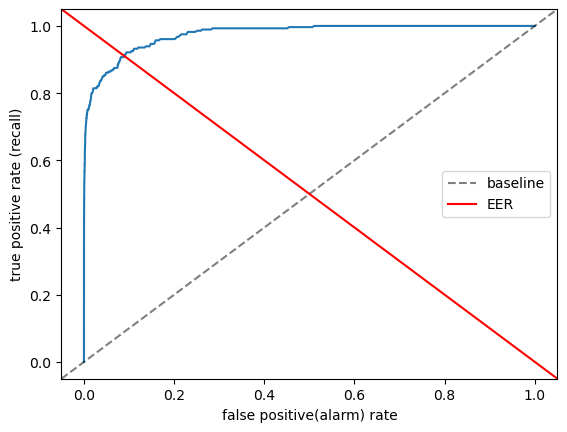

In [18]:
fpr, tpr, thresholds = plot_roc(T, D, 3, 7, num_persons, print_threshold=True)

## T10
Equal Error rate($EER$) $\Rightarrow$ False Alarm Rate $=$ False Negative Rate
\begin{align*}
FAR &= FRR \\
FAR &= 1 - TPR \\
FAR + TPR - 1 &= 0
\end{align*}
use this to find FAR and TPR, and 

$$EER = \frac{FAR + FRR}{2} = \frac{FAR + (1 - TPR)}{2}$$

In [19]:
def compute_eer(tpr, fpr, thresholds=None, return_eer=False):
    mn_idx = np.argmin(np.abs(tpr + fpr - 1))
    far=fpr[mn_idx]
    frr=1-tpr[mn_idx]
    eer=np.mean((far, frr))
    
    if return_eer:
        return eer
        
    print('FAR:', far)
    print('FRR:', frr)
    print(30*'-')
    print('EER:', eer)
    print('EER Threshold', thresholds[mn_idx])

In [20]:
compute_eer(tpr, fpr, thresholds)

FAR: 0.08864468864468865
FRR: 0.09285714285714286
------------------------------
EER: 0.09075091575091576
EER Threshold 8.080841738309047


### False Alarm Rate at reall 0.1%

In [21]:
def recall_at_far_rate(tpr, fpr, rate, thresholds=None, return_recall=False):
    fpr_idx = np.argmin(np.abs(fpr - rate))
    if return_recall:
        return tpr[fpr_idx]
    print('recall rate at far 0.1%:', tpr[fpr_idx])
    print('At threshold:', thresholds[fpr_idx]) 

In [22]:
recall_at_far_rate(tpr, fpr, .001, thresholds)

recall rate at far 0.1%: 0.5428571428571428
At threshold: 5.948289934742019


# Principle Component Analysis (PCA)

## T11

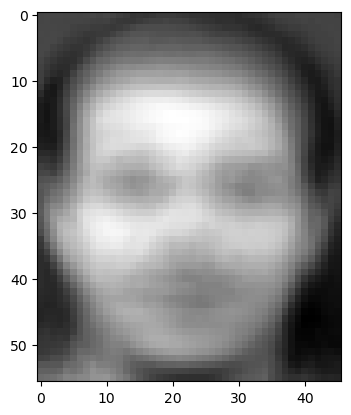

In [23]:
mean_face = T.mean(axis = 0)
plt.imshow(mean_face.reshape(img_h, img_w) ,cmap='gray')
plt.show()

## T12

In [24]:
X = T.T
X_hat = X - mean_face.reshape(-1, 1)
cov_mat = np.cov(X)
print('Covariance Matrix size =', cov_mat.shape)
print('Covariance Matrix rank =', np.linalg.matrix_rank(cov_mat))

Covariance Matrix size = (2576, 2576)
Covariance Matrix rank = 119


## T13

In [25]:
gram_mat = X_hat.T @ X_hat
print('Gram Matrix size =', gram_mat.shape)
print('Gram Matrix rank =', np.linalg.matrix_rank(gram_mat))

eigen_vals, eigen_vecs = np.linalg.eigh(gram_mat) 

# filter out 0 eigen vals
eigen_vecs = eigen_vecs[:, eigen_vals > 1e-6]
eigen_vals = eigen_vals[eigen_vals > 1e-6]

print('Gram Matrix non-zero eigen value =', len(eigen_vals) )

Gram Matrix size = (120, 120)
Gram Matrix rank = 119
Gram Matrix non-zero eigen value = 119


## T14

Yes, The gram matrix is symmetric.
\begin{align*}
\hat{X}^T\hat{X} &= 
\begin{bmatrix}
\rule[.5ex]{2.5ex}{0.5pt} & x_1 & \rule[.5ex]{2.5ex}{0.5pt} \\
\rule[.5ex]{2.5ex}{0.5pt} & x_2 & \rule[.5ex]{2.5ex}{0.5pt} \\
& \vdots & \\
\rule[.5ex]{2.5ex}{0.5pt} & x_N & \rule[.5ex]{2.5ex}{0.5pt} \\
\end{bmatrix}
\begin{bmatrix}
\mid & \mid &  & \mid \\
x_1 & x_2 & \ldots & x_N\\
\mid & \mid &  & \mid
\end{bmatrix} \\
&= \begin{bmatrix}
x_1^Tx_1 & x_1^Tx_2 &  & x_1^Tx_N \\
x_2^Tx_1 & x_2^Tx_1 &  & x_2^Tx_N \\
  & \vdots &  \\
x_N^Tx_1 & x_N^Tx_1 &  & x_N^Tx_N \\
\end{bmatrix}
\end{align*}
$$ \text{and we know that } x_i^Tx_j=x_j^Tx_i $$

## T15

In [26]:
sorted_idx = np.argsort(eigen_vals)[::-1]

eigen_vals = eigen_vals[sorted_idx]
eigen_vecs = eigen_vecs[:, sorted_idx]

print('number of non-zero eigen value:', len(eigen_vals) )
print('highest eigen val:', eigen_vals[0])

number of non-zero eigen value: 119
highest eigen val: 1423.9297148381547


## T16

In [27]:
def search_eigen_amt(eigen_vals, var):
    l, r = 0, len(eigen_vals)+1
    while l < r:
        m = (l+r)>>1
        if _compute_variance(eigen_vals, m) >= var:
            r = m
        else: 
            l = m+1
    return l
def _compute_variance(eigen_vals, amt):
    return eigen_vals[:amt].sum() / eigen_vals.sum()

Amount of eigen vectors = 64
Var= 0.9514558774601827


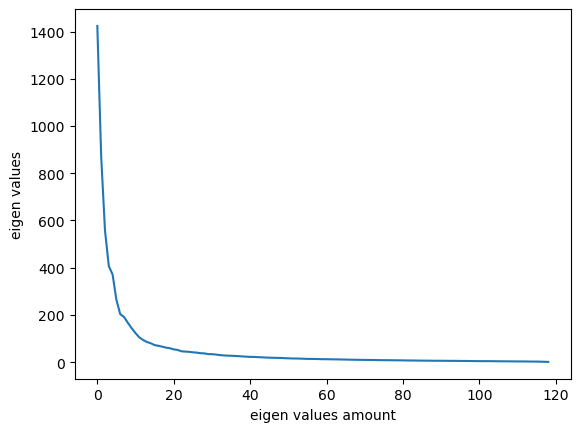

In [28]:
plt.plot(eigen_vals)
plt.ylabel('eigen values')
plt.xlabel('eigen values amount')

print('Amount of eigen vectors =', amt:=search_eigen_amt(eigen_vals, .95) )
print('Var=', _compute_variance(eigen_vals, amt))
plt.show()

## T17

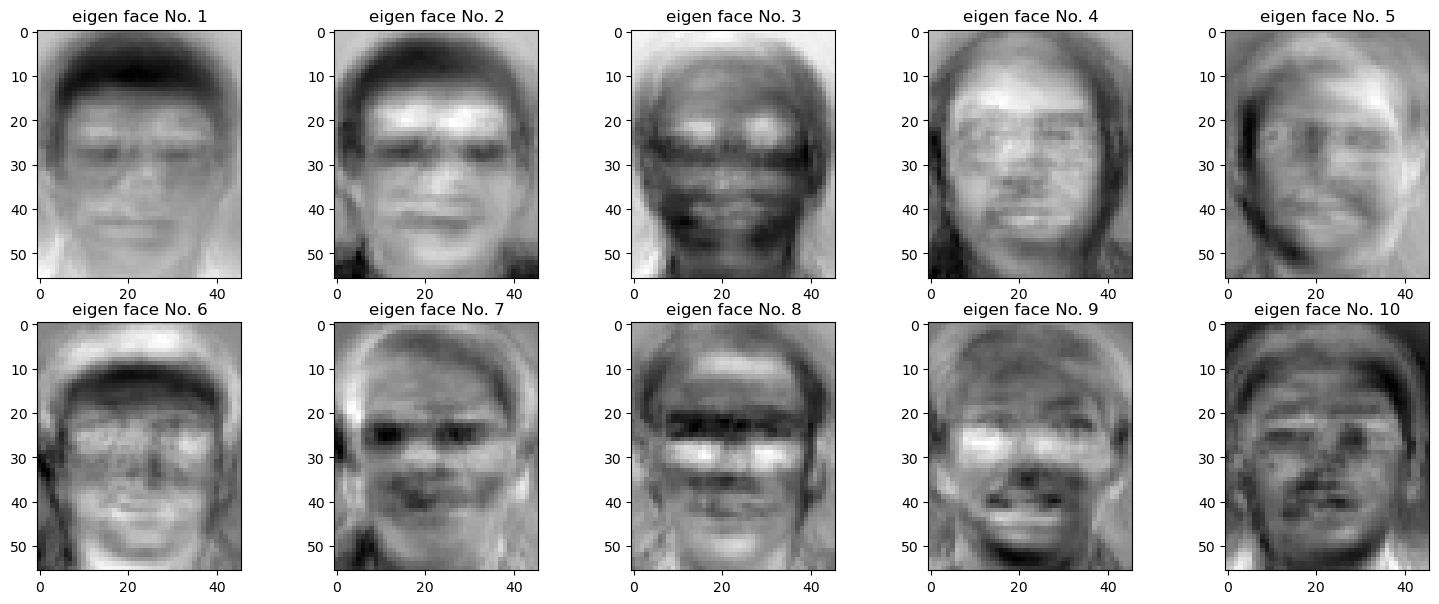

In [29]:
v = X_hat @ eigen_vecs
v = v / np.linalg.norm(v, axis=0)

fig, ax = plt.subplots(2, 5, figsize=(15, 6))
fig.tight_layout()

for i in range(2):
    for j in range(5):
        ax[i, j].set_title(f"eigen face No. {5*i+j+1}")
        ax[i, j].imshow(v[:, 5*i+j].reshape(img_h, img_w), cmap='gray_r')
plt.show()

## T18
The darker pixel show that there is high value in eigen face.<br>

- Eigenface No.1<br>
    - The dark part is hair<br>
- Eigenface No.2<br>
    - The dark part is also hair but there also have eye and collar that have dark part<br>

let see the sample of people<br>

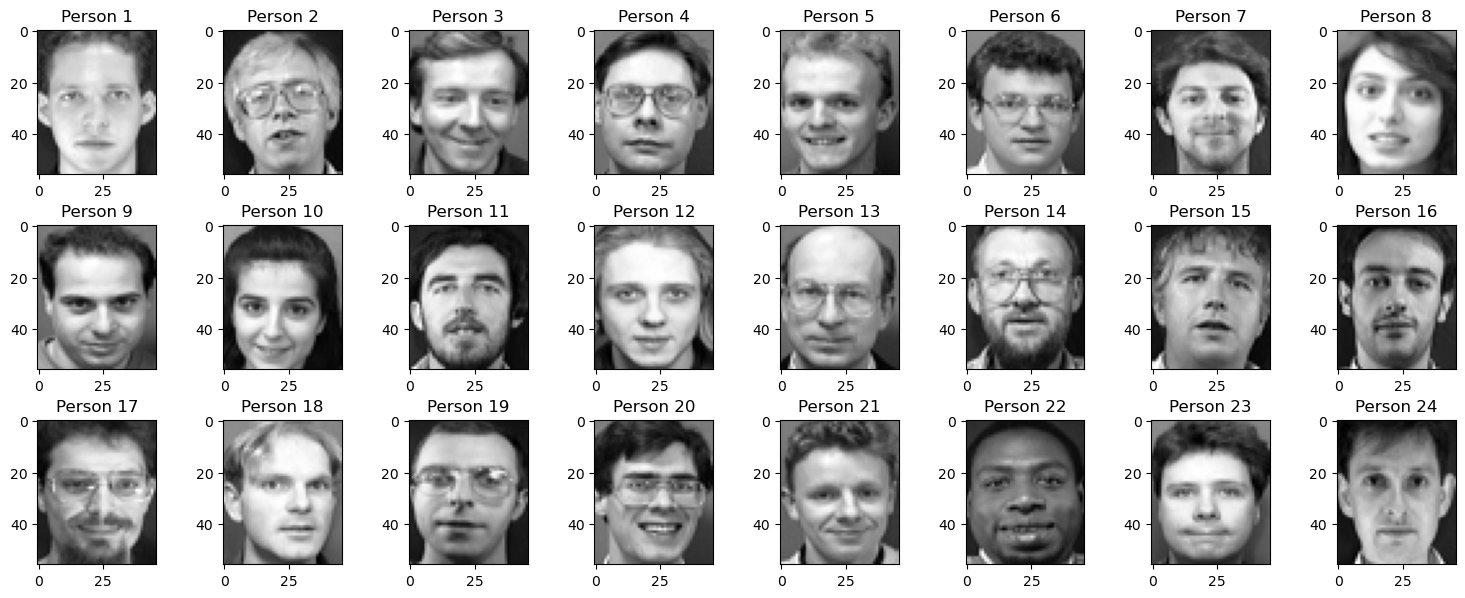

In [30]:
fig, ax = plt.subplots(3, 8, figsize=(15, 6))
fig.tight_layout()

for i in range(3):
    for j in range(8):
        ax[i, j].set_title(f'Person {8*i+j+1}')
        ax[i, j].imshow(xf[8*i+j, 0], cmap='gray')
        
plt.show()

The first and second eigen face are capture the biggest variance of the images because many people have different hair color and style and size of eyes. There also images of people have collar in its so the eigen face will capture it too.

# PCA subspace and the face verification system

## T19

In [31]:
def reduce_dimension(X, v, mean_face, k):
    '''
        X is matrix that have vector in column
    '''
    V = v[:, :k]
    projection = V.T @ (X - mean_face.reshape(-1, 1))
    return projection

def face_verification_pca(train, test, train_sz, test_sz, n_persons, ks, return_roc=False):
    mean_face = train.mean(axis = 0)
    X_hat = (train - mean_face).T
    gram_mat = X_hat.T @ X_hat

    # Compute eigen value
    eigen_vals, eigen_vecs = np.linalg.eigh(gram_mat) 
    eigen_vecs = eigen_vecs[:, eigen_vals > 1e-6]
    eigen_vals = eigen_vals[eigen_vals > 1e-6]
    # Sort by eigen value
    sorted_idx = np.argsort(eigen_vals)[::-1]
    eigen_vals = eigen_vals[sorted_idx]
    eigen_vecs = eigen_vecs[:, sorted_idx]
    
    # compute and normalize v
    v = X_hat @ eigen_vecs
    v = v / np.linalg.norm(v, axis=0)

    eers = np.empty(len(ks))
    recall_at_far = np.empty(len(ks))

    for i, k in enumerate(ks):
        train_reduced = reduce_dimension(train.T, v, mean_face, k).T
        test_reduced = reduce_dimension(test.T, v, mean_face, k).T
        fpr, tpr, _ = roc_curve(train_reduced, test_reduced, train_sz, test_sz, n_persons)

        eers[i] = compute_eer(tpr, fpr, return_eer=True)
        recall_at_far[i] = recall_at_far_rate(tpr, fpr, .001, return_recall = True)
    if return_roc:
        return fpr, tpr
    return eers, recall_at_far

In [32]:
eers, recall_001 = face_verification_pca(T, D, 3, 7, num_persons, [10] )
print("EER at k=10:", *eers)
print("Recall at FAR 0.1%:", *recall_001)

EER at k=10: 0.07875457875457878
Recall at FAR 0.1%: 0.5142857142857142


## T20

Min eer at 0.07811355311355314 at k = 11


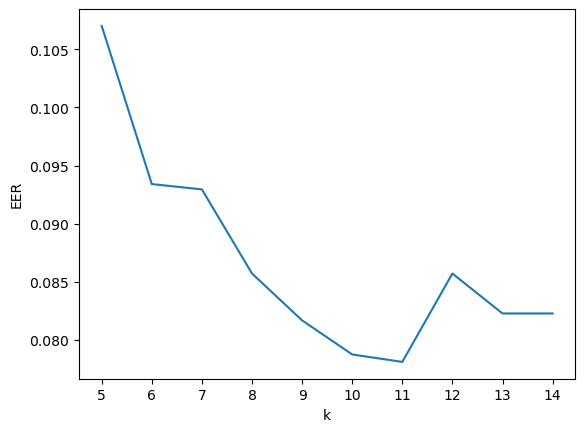

,5,6,7,8,9,10,11,12,13,14
0,0.107005,0.093407,0.092949,0.085714,0.081685,0.078755,0.078114,0.085714,0.08228,0.08228


In [33]:
ks = np.arange(5, 15)
eers, _ = face_verification_pca(T, D, 3, 7, num_persons, ks)
print('Min eer at', eers.min(), 'at k =', ks[eers.argmin()])
pd.DataFrame([eers], columns=ks)

plt.plot(ks, eers)
plt.xticks(ks)
plt.xlabel('k')
plt.ylabel('EER')
plt.show()
pd.DataFrame([eers], columns=ks)

In [34]:
fpr_pca, tpr_pca = face_verification_pca(T, D, 3, 7, num_persons, [11], return_roc = True)

# (Optional) PCA reconstruction

## OT2

MSE: 0.006148335016488302


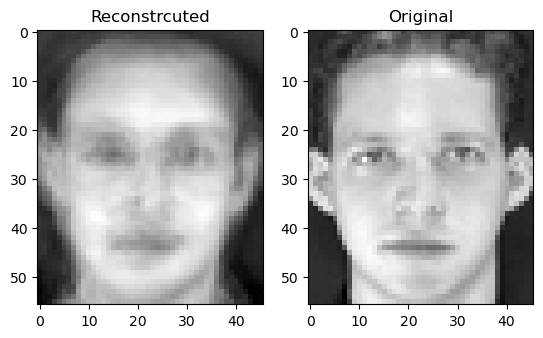

In [35]:
def mean_squarred_error(a, b):
    return np.mean((a-b)**2)
    
def reconstruct_image(mean_face, v, k, projected):
    return mean_face + v[:, :k] @ projected[:k]

k = 10
projected_image = v.T @ (T[0] - mean_face)
reconstructed = reconstruct_image(mean_face, v, k, projected_image)

fig, ax = plt.subplots(1, 2)
ax[0].imshow( reconstructed.reshape(img_h, img_w), cmap='gray')
ax[0].set_title('Reconstrcuted')
ax[1].imshow( T[0].reshape(img_h, img_w), cmap='gray')
ax[1].set_title('Original')

print('MSE:', mean_squarred_error(reconstructed, T[0]))
plt.show()

## OT3

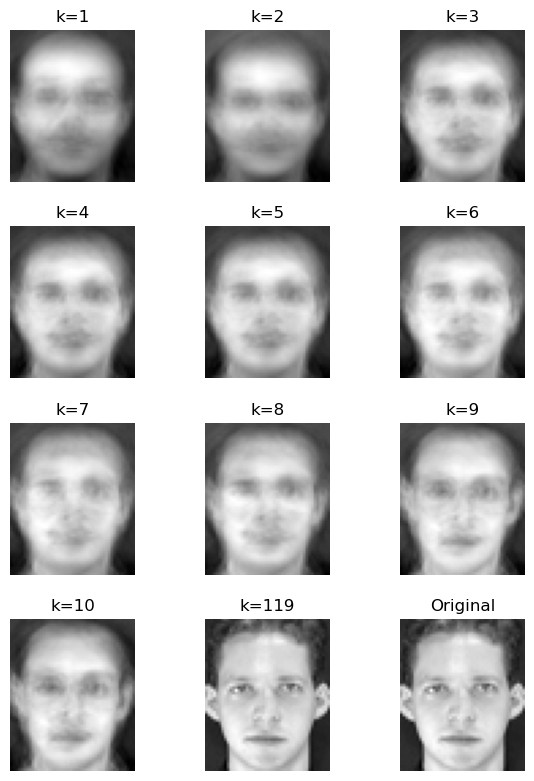

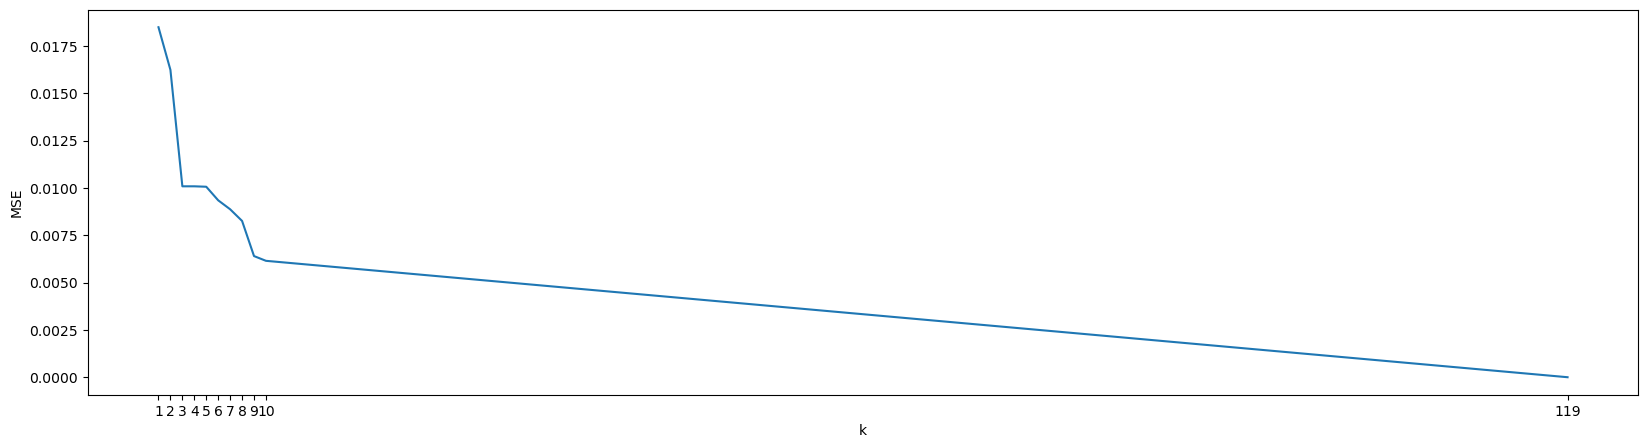

In [36]:
ks = np.block([np.arange(1, 11), 119])
fig, ax = plt.subplots(4, 3, figsize=(6, 8))
fig.tight_layout()

mse_list = np.empty_like(ks, dtype=np.float64)
for i, k in enumerate(ks):
    projected_image = v[:, :k].T @ (T[0] - mean_face)
    reconstructed_img = reconstruct_image(mean_face, v, k, projected_image)
    ax[i//3, i%3].imshow(reconstructed_img.reshape(img_h, img_w), cmap='gray')
    ax[i//3, i%3].set_title(f"k={k}")
    ax[i//3, i%3].set_axis_off()
    mse_list[i] = mean_squarred_error(reconstructed_img, T[0])
    
ax[3, 2].set_title('Original')
ax[3, 2].imshow(T[0].reshape(img_h, img_w), cmap='gray')
ax[3, 2].set_axis_off()
plt.show()

plt.figure(figsize=(20, 5))
plt.plot(ks, mse_list)
plt.ylabel('MSE')
plt.xlabel('k')
plt.xticks(ks)

plt.show()

## OT4
### Original database
total image pixel is $2576$ pixels each. $\\$
$1$ pixel use $32$ bits float datatype. $\\$
$1$ image use $32$ $\times$ $2576$ = $82,432$ bits = $10,304$ bytes per image $\\$
we have total $1,000,000$ images, therefore we use $10,304$ $\times$ $10^6$ bytes = $9.5963$ Gibibytes ($10.304$ Gigabytes)

### PCA database
After projected $2576$ features(pixels)/image $\rightarrow$ $10$ features/image $\\$
All images data $(10 \times 10^6) \times 4$ bytes = 40,000,000 bytes $\\$
Store total $10$ eigen faces and $1$ mean face = $\left((10 + 1) \times 2576\right) \times 4$ btyes = 113,344 bytes $\\$
$\therefore$ total memory usage = $40,113,344$ bytes = $38.2551$ Mebibytes ($40.1133$ Megabytes)

# Linear Discriminant Analysis (LDA)

## T21
$S_W$ has $N-C$ rank due to we compute $C$ mean for each class. For our example $N-C$ is $120 - 40 = 80$ (120 training images with 40 different people)

## T22

In [38]:
def compute_sw(projected_train, num_classes, data_per_class):
    projected_by_class = projected_train.T.reshape(num_classes, data_per_class, -1)
    mean_face_by_class = projected_by_class.mean(axis=1, keepdims=True)
    deviation = (projected_by_class - mean_face_by_class).reshape(num_classes * data_per_class, -1).T # turn back to 80 * 120
    return deviation @ deviation.T
    
def compute_sb(projected_train, num_classes, data_per_class):
    global_mean_faces  = projected_train.mean(axis=1)
    projected_by_class = projected_train.T.reshape(num_classes, data_per_class, -1)
    mean_face_by_class = projected_by_class.mean(axis=1)
    mean_deviation = (mean_face_by_class - global_mean_faces).T
    return mean_deviation @ mean_deviation.T

In [39]:
sw_rank = T.shape[0] - num_persons
projected_train = v[:, :sw_rank].T @ (T - mean_face).T

sw = compute_sw(projected_train, num_persons, 3)
sb = compute_sb(projected_train, num_persons, 3)

lda_proj = np.linalg.inv(sw) @ sb
is_symmetric = (lda_proj-lda_proj.T < 1e-6).all()

print("lda proj is", "symmetric." if is_symmetric else "asymmetric.", end=' ')
print("Therefore, we", "can" if is_symmetric else "can not", "use np.linalg.eigh.")

lda_eigen_vals, lda_eigen_vecs = np.linalg.eig(lda_proj)
lda_eigen_vecs = lda_eigen_vecs.real # only real part

lda_eigen_vecs = lda_eigen_vecs[:, lda_eigen_vals > 1e-6]
lda_eigen_vals = lda_eigen_vals[lda_eigen_vals > 1e-6]
sorted_idx = np.argsort(lda_eigen_vals)[::-1]

lda_eigen_vecs = lda_eigen_vecs[:, sorted_idx]
lda_eigen_vals = lda_eigen_vals[sorted_idx]


print("sw rank", np.linalg.matrix_rank(sw))
print("sb rank", np.linalg.matrix_rank(sb))
print("lda proj rank", np.linalg.matrix_rank(lda_proj))

print("number of non zero eigen values", len(lda_eigen_vals))

lda proj is asymmetric. Therefore, we can not use np.linalg.eigh.
sw rank 80
sb rank 39
lda proj rank 39
number of non zero eigen values 39


## T23

(2576, 39)


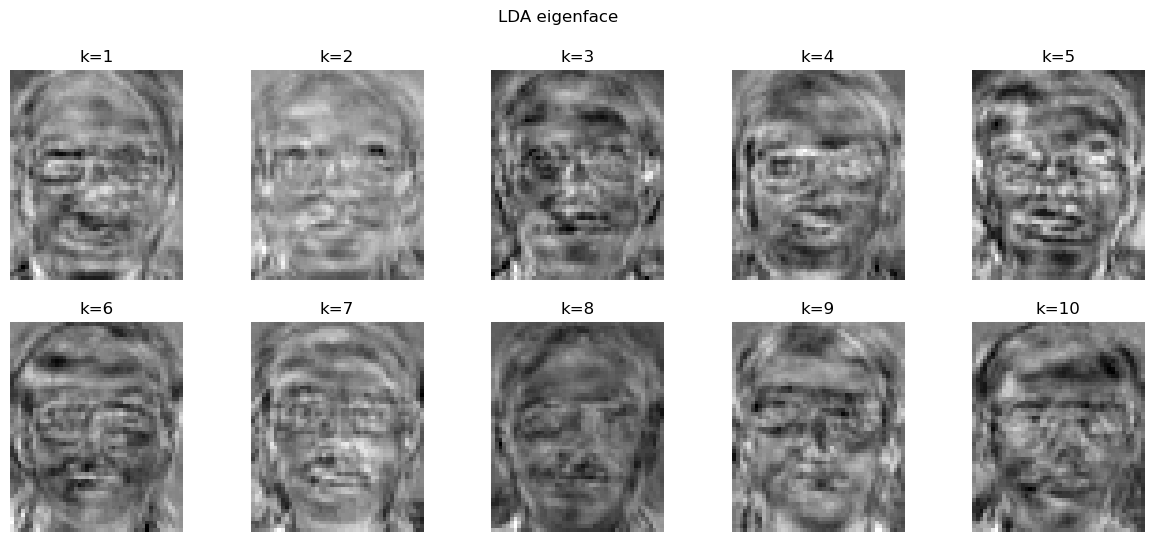

In [69]:
# lda eigen -> pca -> image
lda_eigen_constructed = v[:, :sw_rank] @ lda_eigen_vecs
print(lda_eigen_constructed.shape)

fig, ax = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('LDA eigenface')

for k in range(10):
    i, j = k // 5, k % 5
    ax[i, j].imshow(lda_eigen_constructed[:, k].reshape(img_h, img_w), cmap='gray_r')
    ax[i, j].set_title(f"k={k+1}")
    ax[i, j].set_axis_off()

plt.show()

LDA eigenface tell what different between each people

## T24

In [41]:
projected_train_lda = lda_eigen_constructed.T @ T.T
projected_test_lda = lda_eigen_constructed.T @ D.T

fpr_lda, tpr_lda, _ = roc_curve(projected_train_lda.T, projected_test_lda.T, 3, 7, num_persons)
eer = compute_eer(tpr_lda, fpr_lda, return_eer=True)
recall = recall_at_far_rate(tpr_lda, fpr_lda, .001, return_recall = True)

print("EER", eer)
print("Recall at FAR 0.1%:", recall)

EER 0.07170329670329668
Recall at FAR 0.1%: 0.6821428571428572


## T25

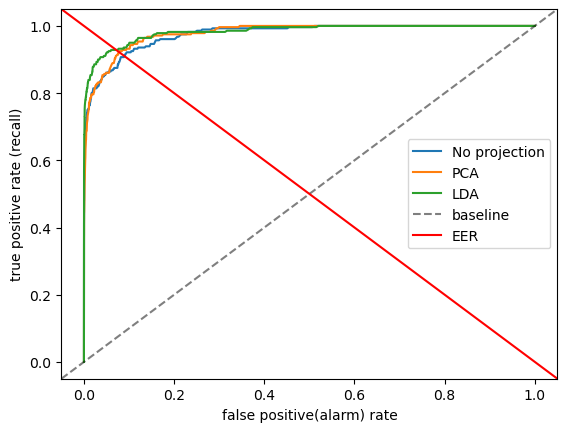

In [42]:
plt.plot(fpr, tpr, label='No projection')
plt.plot(fpr_pca, tpr_pca, label='PCA')
plt.plot(fpr_lda, tpr_lda, label='LDA')

plt.axline((0, 0), slope=1, c='k', linestyle = '--', alpha=0.5, label='baseline')
plt.axline((1, 0), slope=-1, c='r', label='EER')


plt.xlabel('false positive(alarm) rate')
plt.ylabel('true positive rate (recall)')

plt.legend()
plt.show()

LDA has the best performance. :)

## OT5

In [43]:
def plot_cluster(projected_data, samples_size, img_per_sample):
    plt_dim = projected_data[:2, :samples_size * img_per_sample].T
    plt_x, plt_y = plt_dim[:, 0], plt_dim[:, 1]
    plt_x = plt_x.reshape(samples_size, img_per_sample)
    plt_y = plt_y.reshape(samples_size, img_per_sample)
    color = ['g', 'r', 'b', 'purple', 'magenta', 'orange', 'cyan']
    plt.figure(figsize=(10, 10))
    for i in range(samples_size):
        plt.scatter(plt_x[i], plt_y[i], c=color[i], label=str(i+1))
    plt.legend()
    plt.show()

### LDA

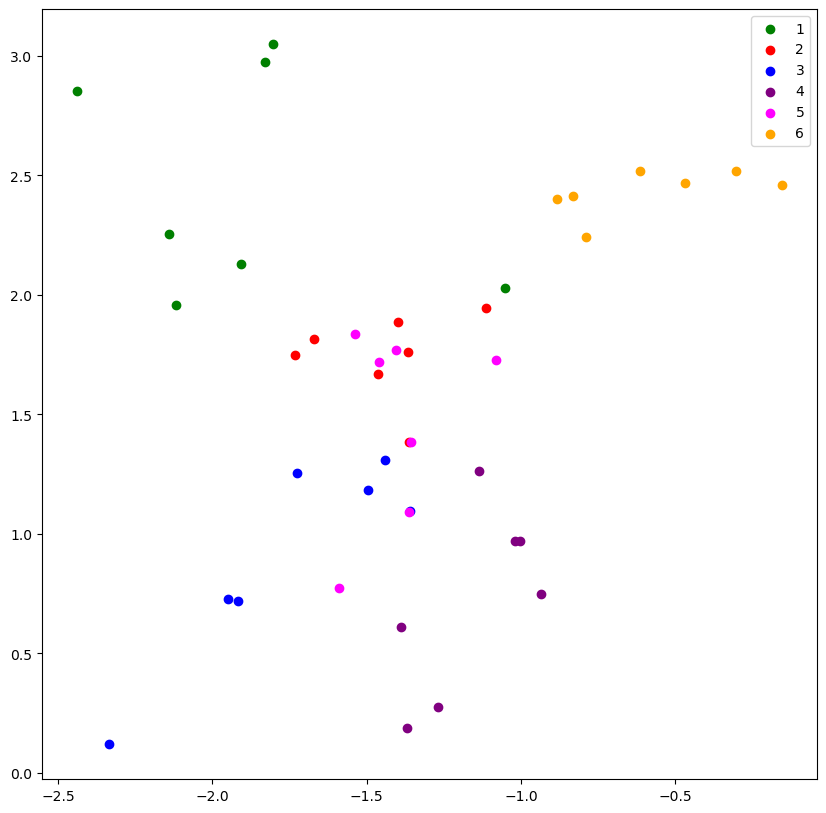

In [66]:
plot_cluster(projected_test_lda, 6, 7)

### PCA

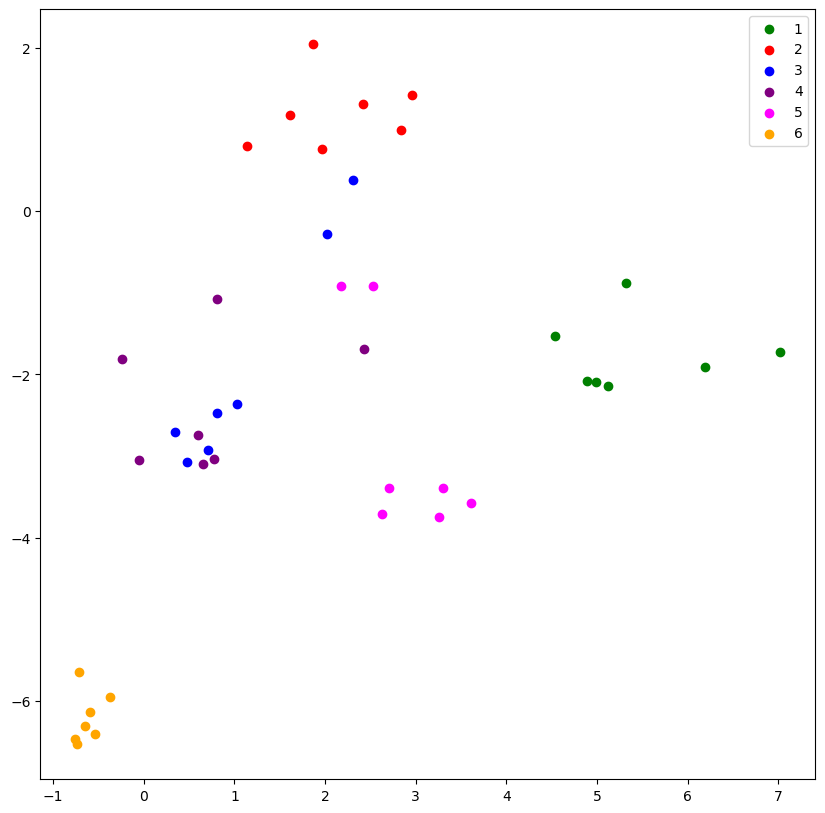

In [76]:
projected_pca = reduce_dimension(D.T, v, mean_face, 2)
plot_cluster(projected_pca, 6, 7)

The result seem that PCA is better cluster than LDA (not as my expected). I think the main reason is our LDA is compressed from the PCA (to make $S_w$ invertible, non-singular).